In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

import pandas
import matplotlib.pyplot as plt
import altair as alt

In [4]:
# Load StrainGST data
BASE_PATH = Path("umb")

straingst_data = []
sample_names = []
for fpath in BASE_PATH.glob("straingst/*.tsv"):
    sample = fpath.stem
    
    if sample[-1].isalpha():
        continue
        
    df = pandas.read_csv(fpath, sep='\t', index_col=1, skiprows=2, comment='#')
    straingst_data.append(df)
    sample_names.append(sample)
    
straingst_df = pandas.concat(straingst_data, keys=sample_names, names=["sample"])

sample_names = list(sorted(sample_names, key=lambda e: float(e.replace("UMB11_", ""))))
sample_names = sample_names[:-1]  # Remove empty UMB11_12
straingst_df = straingst_df.loc[sample_names].copy()

In [36]:
straingst_df

i gkmers ikmers  \
sample     strain                                                            
UMB11_01   Esch_coli_NGF1                                  0  49631  49622   
UMB11_02   Esch_coli_NGF1                                  0  49631  49623   
UMB11_03   Esch_coli_1190                                  0  48261  48249   
UMB11_03.1 Esch_coli_1190                                  0  48261  48254   
UMB11_04.1 Esch_coli_1190                                  0  48261  48250   
UMB11_06   Esch_coli_H3                                    0  45610  45560   
           Esch_coli_1190                                  1  48261  21600   
UMB11_07   Esch_coli_1190                                  0  48261  48237   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  1  47727  21265   
UMB11_08   Esch_coli_1190                                  0  48261  48248   
UMB11_11   Esch_coli_1190                                  0  48261  48248   

                                                          skmers    cov  \
sample     strain                                                         
UMB11_01   Esch_coli_NGF1                                  50090  0.985   
UMB11_02   Esch_coli_NGF1                                   5358  0.103   
UMB11_03   Esch_coli_1190                                  37144  0.711   
UMB11_03.1 Esch_coli_1190                                  31201  0.595   
UMB11_04.1 Esch_coli_1190                                  19042  0.362   
UMB11_06   Esch_coli_H3                                    74449  0.960   
           Esch_coli_1190                                  30714  0.794   
UMB11_07   Esch_coli_1190                                  58276  0.854   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  17074  0.441   
UMB11_08   Esch_coli_1190                                  31599  0.592   
UMB11_11   Esch_coli_1190                                  49462  0.920   

                                                              kcov     gcov  \
sample     strain                                                             
UMB11_01   Esch_coli_NGF1                                    7.009    6.831   
UMB11_02   Esch_coli_NGF1                                    1.546    0.158   
UMB11_03   Esch_coli_1190                                    2.814    1.975   
UMB11_03.1 Esch_coli_1190                                    2.152    1.264   
UMB11_04.1 Esch_coli_1190                                    1.870    0.668   
UMB11_06   Esch_coli_H3                                    114.343  109.038   
           Esch_coli_1190                                    7.102    5.565   
UMB11_07   Esch_coli_1190                                    4.557    3.846   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8    2.588    1.077   
UMB11_08   Esch_coli_1190                                    2.243    1.309   
UMB11_11   Esch_coli_1190                                    6.107    5.545   

                                                            acct   even  \
sample     strain                                                         
UMB11_01   Esch_coli_NGF1                                  0.980  0.987   
UMB11_02   Esch_coli_NGF1                                  0.932  0.707   
UMB11_03   Esch_coli_1190                                  0.926  0.826   
UMB11_03.1 Esch_coli_1190                                  0.918  0.830   
UMB11_04.1 Esch_coli_1190                                  0.908  0.743   
UMB11_06   Esch_coli_H3                                    0.921  0.960   
           Esch_coli_1190                                  0.283  0.797   
UMB11_07   Esch_coli_1190                                  0.803  0.873   
           Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8  0.526  0.668   
UMB11_08   Esch_coli_1190                                  0.904  0.810   
UMB11_11   Esch_coli_1190                                  0.920  0.923   

                                                            spec

In [5]:
# Load StrainGR data
straingr_data = []
for sample in sample_names:
    straingr_tsv = BASE_PATH / f"straingr/{sample}.tsv"
    df = pandas.read_csv(straingr_tsv, sep='\t', index_col=[0, 1])
    df = df.drop(index='TOTAL', level=0)
    straingr_data.append(df)
    
straingr_df = pandas.concat(straingr_data, keys=sample_names)
straingr_df = straingr_df[straingr_df['length'] > 3e6]
straingr_df['enough_cov'] = straingr_df['coverage'] > 0.5

# Load StrainGR compare data
compare_df = pandas.read_csv(BASE_PATH / "straingr/compare.summary.1190.txt", sep='\t', index_col=[0, 1, 2])

def enough_cov(ix):
    sample1, sample2, ref = ix
    
    if (sample1, ref) not in straingst_df.index or (sample2, ref) not in straingst_df.index:
        return False
    
    return straingr_df.loc[(sample1, ref), 'enough_cov'][0] and straingr_df.loc[(sample2, ref), 'enough_cov'][0]

compare_df['enough_cov'] = compare_df.index.map(enough_cov)
compare_pass_qc = compare_df[compare_df['enough_cov'] & (compare_df['commonPct'] > 0.5)]

/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/pandas/core/indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [6]:
c1 = alt.Chart(compare_pass_qc.reset_index()).mark_point().encode(
    alt.X('gapJaccardSim', scale=alt.Scale(zero=False, domain=[0.97, 1.0]), title="Gap Similarity"),
    alt.Y('singleAgreePct', scale=alt.Scale(zero=False, domain=[99.9, 100]), title="Pairwise ACNI [%]"),
    size=alt.Size('commonPct', type="quantitative", title="Common Callable [%]",
                  scale=alt.Scale(range=(25, 300))),
    tooltip=['sample1', 'sample2', 'ref', 'commonPct', 'singleAgreePct', 'gapJaccardSim', 'sharedAllelesPct']
)

c1.properties(width=300, height=150)

alt.Chart(...)

## Load coverage and variant calls

In [7]:
import numpy
import pysam

from strainge.variant_caller import ALLELE_MASKS
from strainge.io.variants import call_data_from_hdf5

CONTIG_1190 = "NZ_CP023386.1"
LENGTH_1190 = 4900891
SUBSAMPLE = 10

coverages = {
    'sample': [],
    'pos': [],
    'cov': [],
}

callable_matrix = numpy.zeros((len(sample_names), LENGTH_1190), dtype=bool)
variant_matrix = numpy.zeros((len(sample_names), LENGTH_1190), dtype=numpy.uint8)
variant_matrix_weak = numpy.zeros((len(sample_names), LENGTH_1190), dtype=numpy.uint8)

pos = numpy.arange(LENGTH_1190)
pos_subsampled = pos[::SUBSAMPLE]

for row, sample in enumerate(sample_names):
    if (sample, "Esch_coli_1190") not in straingst_df.index:
        continue
        
    hdf5_path = BASE_PATH / f"straingr/{sample}.hdf5"
    call_data = call_data_from_hdf5(hdf5_path)
    
    callable_smoothed = pandas.Series(call_data.scaffolds_data[CONTIG_1190].strong > 0).rolling(
        100, min_periods=1, center=True).sum() >= 2
    callable_matrix[row, :] = callable_smoothed
    
    variant_matrix[row, :] = call_data.scaffolds_data[CONTIG_1190].strong & ~call_data.scaffolds_data[CONTIG_1190].refmask
    variant_matrix[row, call_data.scaffolds_data[CONTIG_1190].lowmq] = 0
    
    variant_matrix_weak[row, :] = call_data.scaffolds_data[CONTIG_1190].weak & ~call_data.scaffolds_data[CONTIG_1190].refmask
    variant_matrix_weak[row, call_data.scaffolds_data[CONTIG_1190].lowmq] = 0
    
sample_ix = numpy.array([[sample] * len(pos_subsampled) for sample in sample_names])
callable_df = pandas.DataFrame({
    'sample': sample_ix.flatten(),
    'pos': numpy.tile(pos_subsampled, len(sample_names)),
    'callable': callable_matrix[:, ::SUBSAMPLE].flatten()
}).set_index('sample')

del callable_matrix


/cil/shed/apps/internal/conda/envs/strainge/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [8]:
# Check which variants are observed in at least three samples
per_sample_alleles = (variant_matrix[:, :, numpy.newaxis] & ALLELE_MASKS[numpy.newaxis, numpy.newaxis, :4]).astype(bool)
per_sample_alleles_weak = (variant_matrix_weak[:, :, numpy.newaxis] & ALLELE_MASKS[numpy.newaxis, numpy.newaxis, :4]).astype(bool)

allele_counts_across_samples = per_sample_alleles.sum(axis=0)

In [25]:
Allele(12)

<Allele.T|G: 12>

In [35]:
from strainge.variant_caller import Allele

total_strong_across_samples = numpy.count_nonzero(allele_counts_across_samples > 0)
total_strong_2samples = numpy.count_nonzero(allele_counts_across_samples > 1)
total_strong_3samples = numpy.count_nonzero(allele_counts_across_samples > 2)

print("total strongly called across all samples:", total_strong_across_samples)
print("- at least two samples:", total_strong_2samples)
print("- at least three samples:", total_strong_3samples)

# Exclude weak alleles not strongly called in *any* sample
weak_alleles_exclude = allele_counts_across_samples < 1
per_sample_weak = per_sample_alleles_weak.copy()
per_sample_weak[:, weak_alleles_exclude] = 0

weak_counts_across_samples = per_sample_weak.sum(axis=0)

total_weak_2samples = numpy.count_nonzero(weak_counts_across_samples > 1)
total_weak_3samples = numpy.count_nonzero(weak_counts_across_samples > 2)
total_weak_5samples = numpy.count_nonzero(weak_counts_across_samples > 4)
total_weak_6samples = numpy.count_nonzero(weak_counts_across_samples > 5)

print("weakly called in")
print("- at least two samples:", total_weak_2samples)
print("- at least three samples:", total_weak_3samples)
print("- at least five samples:", total_weak_5samples)
print("- at least six samples:", total_weak_6samples)

pos_one_strong_and_five_weak = (allele_counts_across_samples.sum(axis=-1) > 0) & (weak_counts_across_samples.sum(axis=-1) > 4)
weak_alleles = variant_matrix[:, pos_one_strong_and_five_weak]

# Ensure that places without read data (weak == 0) don't affect bitwise AND
weak_alleles[weak_alleles == 0] |= 0xFFFF
print(weak_alleles.shape)

consistent_alleles = numpy.bitwise_and.reduce(weak_alleles, axis=0)
print(consistent_alleles.shape)
print(numpy.count_nonzero(consistent_alleles), "/", numpy.count_nonzero(pos_one_strong_and_five_weak))

pos = numpy.arange(LENGTH_1190)[pos_one_strong_and_five_weak]
for i in range(len(consistent_alleles)):
    var_pos = pos[i]
    print(var_pos, "; ".join(str(Allele(int(variant_matrix_weak[j, var_pos]))) for j in range(variant_matrix_weak.shape[0])), "-", str(Allele(int(consistent_alleles[i]))))


total strongly called across all samples: 3098
- at least two samples: 817
- at least three samples: 302
weakly called in
- at least two samples: 1623
- at least three samples: 1209
- at least five samples: 295
- at least six samples: 73
(11, 295)
(295,)
295 / 295
14267 ; ; G; ; ; G; ; G; ; G; G - G
66066 ; ; T; T; ; ; ; T; T; ; T - T
117539 ; ; A; A; ; A; ; A; A; ; A - A
175839 ; ; G; G; ; ; ; G; G; G; G - G
205661 ; ; ; C; ; ; ; C; C; C; C - C
210231 ; ; T; ; ; T; ; T; T; ; T - T
248066 ; ; G; ; ; ; ; G; G; G; G - G
261839 ; ; ; T; ; ; ; T; T; T; T - T
265336 ; ; G; ; ; G; ; G; ; G; G - G
296378 ; ; A; A; ; ; ; ; A; A; A - A
310602 ; ; G; G; ; ; ; G; ; G; G - G
347214 ; ; A; ; ; A; ; A; A; ; A - A
490994 ; ; G; ; ; G; ; G; G; ; G - G
501459 ; ; G; ; ; ; ; G; G; G; G - G
629966 ; ; A; A; ; ; ; ; A; A; A - A
751197 ; ; G; ; ; ; ; G; G; G; G - G
751198 ; ; G; ; ; ; ; G; G; G; G - G
762712 ; ; C; C; ; ; ; C; C; C; C - C
846779 ; ; T; T; ; ; ; T; T; ; T - T
847518 ; ; C; C; ; C; ; ; C; C;

In [ ]:
alleles_exclude = allele_counts_across_samples < 3
per_sample_alleles_pass = per_sample_alleles.copy()
per_sample_alleles_pass[:, alleles_exclude] = 0

per_sample_variants = per_sample_alleles_pass.sum(axis=-1) > 0
print(per_sample_variants.shape)

variant_density_data = {
    'sample': [],
    'pos': [],
    'density': []
}

for row, sample in enumerate(sample_names):
    density = pandas.Series(per_sample_variants[row], dtype=numpy.uint32).rolling(1000, min_periods=1, center=True).sum()
    variant_density_data['pos'].extend(pos_subsampled)
    variant_density_data['density'].extend(density[::SUBSAMPLE])
    variant_density_data['sample'].extend([sample] * len(pos_subsampled))
    

var_density_df = pandas.DataFrame(variant_density_data).set_index('sample')

In [8]:
print(cov_df['cov'].min())
print(cov_df['cov'].max())
print()

print(var_density_df['density'].min())
print(var_density_df['density'].max())
print()

print(cov_df['pos'].min())
print(cov_df['pos'].max())
print(var_density_df['pos'].min())
print(var_density_df['pos'].max())
print()

print(len(cov_df['cov']) / len(cov_df.index.unique()))
print(len(var_density_df['density']) / len(cov_df.index.unique()))

0.0
134.36

0.0
21.0

0
4900890
0
4900890

490090.0
490090.0


## Plot StrainGST results, callable, gaps and SNVs

In [9]:
from strainge.utils import find_consecutive_groups
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def gen_patches_from_array(callable, pos, offset, height):
    patches = []
    
    for group, start, end, length in find_consecutive_groups(callable):
        if not numpy.all(group):
            continue
            
        # Round to nearest 100
        start = int(round(pos[start], -2))
        end = int(round(pos[end-1], -2))
        if start == end:
            end += 100
            
        width = end - start
        p = Rectangle((start, offset), width, height)
        patches.append(p)
        
    return patches


def gen_patches_from_bed(fname, offset, height, index=None):
    patches = []
    
    features = pandas.read_csv(fname, sep="\t", index_col=0, names=["chromosomes", "start", "end"])
    
    if index:
        features = features.loc[index]
    
    for start, end in features.itertuples(index=False):
        width = end - start
        p = Rectangle((start, offset), width, height)
        patches.append(p)
        
    return patches

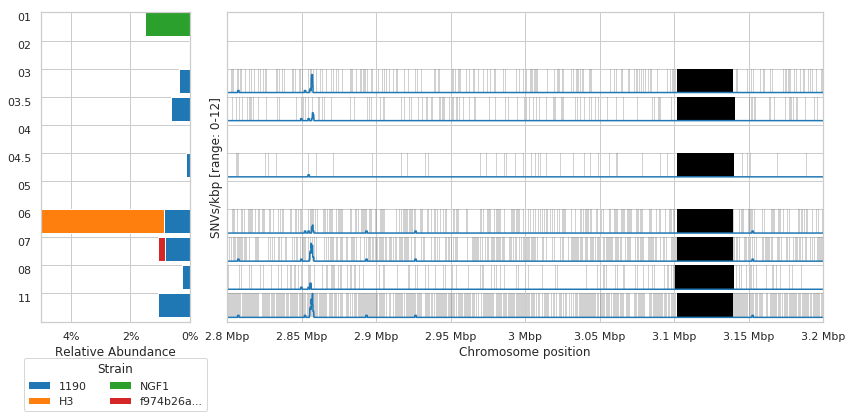

In [10]:
import seaborn
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import EngFormatter, StrMethodFormatter

seaborn.set_style("whitegrid")
seaborn.set_context("notebook")

BARHEIGHT = 0.85

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey='row', gridspec_kw={"width_ratios": [1.5, 6]})

strain_order = ['Esch_coli_1190', 'Esch_coli_H3', 'Esch_coli_NGF1', 'Esch_coli_f974b26a-5e81-11e8-bf7f-3c4a9275d6c8']
strain_labels = ['1190', 'H3', 'NGF1', 'f974b26a...']
colors = seaborn.color_palette("tab10")
labels = [s.replace("UMB11_", "").replace(".1", ".5") for s in sample_names]

# Stacked barplot with StrainGST results
bottom = numpy.zeros(len(sample_names))
for ref, label, color in zip(strain_order, strain_labels, colors):
    ra = numpy.array([straingst_df.loc[(sample, ref), 'rapct'] if (sample, ref) in straingst_df.index else 0.0 for sample in sample_names])
    axes[0].barh(numpy.arange(len(sample_names)), ra, left=bottom, color=color, align='edge', tick_label=labels, label=label, height=BARHEIGHT)
    
    bottom += ra

axes[0].set_xlim(0, 5)
axes[0].set_ylim(0, len(sample_names))
axes[0].set_xlabel("Relative Abundance")
axes[0].xaxis.set_major_formatter(StrMethodFormatter("{x:g}%"))
axes[0].invert_xaxis()
axes[0].invert_yaxis()

axes[0].set_yticklabels(labels, va='top')
axes[0].legend(title="Strain", loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

XMIN = 2.8e6
XMAX = 3.2e6
axes[1].set_xlim(XMIN, XMAX)

callable_in_range = callable_df[(callable_df['pos'] > XMIN) & (callable_df['pos'] <= XMAX)]

# Collect callable and gaps
callable_patches = []
gap_patches = []
for offset, sample in enumerate(sample_names):
    if (sample, "Esch_coli_1190") not in straingst_df.index:
        continue
        
    callable_patches.extend(gen_patches_from_array(callable_in_range.loc[sample, 'callable'].values, 
                                                   callable_in_range.loc[sample, 'pos'].values, 
                                                   offset, BARHEIGHT))
    #callable_patches.extend(gen_patches_from_bed(f"umb/straingr/{sample}.callable.bed", offset, BARHEIGHT, CONTIG_1190))
    gap_patches.extend(gen_patches_from_bed(f"umb/straingr/{sample}.gaps.bed", offset, BARHEIGHT, CONTIG_1190))
        
axes[1].add_collection(PatchCollection(callable_patches, facecolors="dimgrey", linewidths=0, alpha=0.3))
axes[1].add_collection(PatchCollection(gap_patches, facecolors="black", linewidths=0, alpha=1.0))

snv_density_scaler = MinMaxScaler(feature_range=(0, BARHEIGHT))
var_density_in_range = var_density_df[(var_density_df['pos'] > XMIN) & (var_density_df['pos'] <= XMAX)].copy()
var_density_in_range.loc[:, 'density_scaled'] = snv_density_scaler.fit_transform(var_density_in_range['density'].values.reshape(-1, 1)).flatten()

density_min = var_density_in_range['density'].min()
density_max = var_density_in_range['density'].max()

# Plot SNV density
for offset, sample in enumerate(sample_names):
    if (sample, "Esch_coli_1190") not in straingst_df.index:
        continue
        
    sample_density = var_density_in_range.loc[sample]
    density_y = offset - sample_density['density_scaled'].values
    axes[1].plot(sample_density['pos'].values, density_y+BARHEIGHT, color=colors[0])

axes[1].xaxis.set_major_formatter(EngFormatter(unit='bp')) 
axes[1].set_xlabel("Chromosome position")
axes[1].set_ylabel(f"SNVs/kbp [range: {density_min:g}-{density_max:g}]")
fig.tight_layout()
fig.subplots_adjust(wspace=0.1)
fig.savefig('umb11.svg', bbox_inches='tight')